In [102]:
from src.simulators.WF_sim import simulate_waveforms
import sys,os
sys.path.insert(0,'/Users/mxd6118/Desktop/DiffSim')
import pandas as pd
import pickle
from jax import random, device_put
import time
from jax.example_libraries import stax
from jax import jit,vmap, grad
import numpy as np
import jax.numpy as jnp
import jax
import sklearn

import matplotlib.pyplot as plt

key = random.PRNGKey(int(time.time()))
        
key, subkey = random.split(key)

In [13]:
def build_dataloader(number_of_events):
    sys.path.insert(0,'/Users/mxd6118/Desktop/DiffSim/src/utils')
    from dataloaders.krypton_DATES_CUSTOM_DROPOUT import krypton
    # Load the sipm database:
    sipm_db = pd.read_pickle("/Users/mxd6118/Desktop/DiffSim/database/new_sipm.pkl")

    dl = krypton(
        batch_size  = number_of_events,
        db          = sipm_db,
        path        = "/Users/mxd6118/Desktop/DiffSim/kdst",
        run         = 8530,
        shuffle = True,
        drop = 0,
        z_slice = 0,
        )

    return dl

def load_state(file):
    with open(file,"rb") as f:
        params = pickle.load(f)
    return params
    
params_dir = '/Users/mxd6118/Desktop/GAN/src/simulators/'
params_path = os.path.join(params_dir ,"trained_params.pickle")


In [137]:
def init_params(sim_params,subkey):
    
    dis_init, dis_apply = stax.serial(
        stax.Flatten,
        stax.Dense(128),stax.Sigmoid,
        stax.Dense(16), stax.Sigmoid,
        stax.Dense(2),stax.Softmax
    )


    dis_out_size, dis_network_params = dis_init(subkey,(1,47,47))

    parameters = {
    'D_parameters': dis_network_params,
    'S_parameters': sim_params,
    }

    return parameters, dis_apply


def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-8 # Small value to avoid division by zero
    y_pred = jnp.clip(y_pred, epsilon, 1.0 - epsilon)  # Clip values to prevent NaNs
    loss = -(y_true * jnp.log(y_pred) + (1 - y_true) * jnp.log(1 - y_pred))
    return jnp.mean(loss)

In [138]:
@jit
def gen_noise_constant(sipm_waveforms,subkey):

    noise_constant = random.uniform(subkey,shape = sipm_waveforms.shape,minval = -0.5, maxval = 1)
    #noise_constant = random.poisson(subkey,shape = sipm_waveforms.shape,lam = 0.05)
    #noise_constant = random.beta(subkey,shape = sipm_waveforms.shape,a = 2, b = 5)

    return noise_constant
xy_gen_noise_constant = jit(vmap(gen_noise_constant,in_axes=[0,None]))
event_gen_noise_constant = jit(vmap(xy_gen_noise_constant,in_axes=[0,None]))
batch_gen_noise_constant = jit(vmap(event_gen_noise_constant,in_axes=[0,None]))


In [139]:
dataloader = build_dataloader(10)
batch = next(dataloader.iterate())

sim_params = load_state(params_path)

parameters, dis_apply = init_params(sim_params,subkey)

In [140]:
import matplotlib.pyplot as plt
import sklearn


noise = batch_gen_noise_constant(batch['S2Si'],subkey)

simulated_pmts, simulated_sipms = simulate_waveforms(batch['energy_deposits'],
                                                    parameters['S_parameters'], noise, key)



In [150]:

train_batch_filtered = {}
train_batch_filtered['S2Si'] = []
train_batch_filtered['SIPM_FAKE'] =[]

for i in range(real.shape[0]):
    for j in range(real.shape[3]):

        train_batch_filtered['SIPM_FAKE'].append(jax.lax.select(jnp.any(real[i,:,:,j] != 0),
                                                        fake[i,:,:, j],
                                                        jnp.empty(shape = fake[i,:,:, j].shape)))

        train_batch_filtered['S2Si'].append(jax.lax.select(jnp.any(real[i,:,:,j] != 0),
                                                        real[i,:,:, j],
                                                        jnp.empty(shape = real[i,:,:, j].shape)))


#non_zeros_fakes = jnp.any(jnp.stack(train_batch_filtered['SIPM_FAKE']) != 0,axis=(-1,1))
#non_zeros_reals = jnp.any(jnp.stack(train_batch_filtered['S2Si']) != 0,axis=(-1,1))

#mask_fake = device_put(non_zeros_fakes).nonzero()[0]
#mask_real = device_put(non_zeros_reals).nonzero()[0]

# Reshape the resulting array to shape (m, 47, 47)
train_batch_filtered['SIPM_FAKE'] = jnp.stack(train_batch_filtered['SIPM_FAKE'])#[mask_fake]
train_batch_filtered['S2Si'] = jnp.stack(train_batch_filtered['S2Si'])#[mask_real]


l = len(train_batch_filtered['S2Si'])

train_batch_filtered['train'] = jnp.vstack((train_batch_filtered['S2Si'],
                                           train_batch_filtered['SIPM_FAKE']))

labels =[]

for c in range(0,2*l):
    if c < l:
        labels.append(np.array([1,0]))
    else:
        labels.append(np.array([0,1]))

train_batch_filtered['Labels'] = np.array(labels)


train, labels = sklearn.utils.shuffle(train_batch_filtered['train'],
                                      train_batch_filtered['Labels'])


batch_all = {'Train': train, 'Labels' :labels}

In [153]:
fake_labels = dis_apply(parameters['D_parameters'],batch_all['Train'])

binary_cross_entropy(batch_all['Labels'], fake_labels)

Array(0.78567934, dtype=float32)

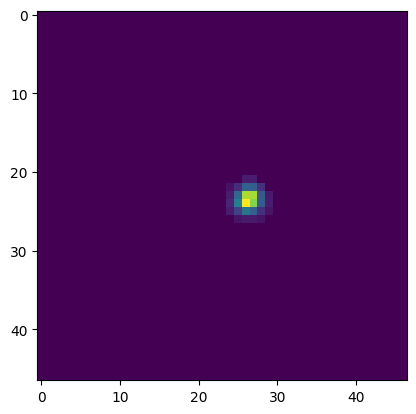

In [101]:
plt.imshow(filtered[15])

In [ ]:
train_batch_filtered['SIPM_FAKE'] = jnp.stack(train_batch_filtered['SIPM_FAKE'])
train_batch_filtered['S2Si']= jnp.stack(train_batch_filtered['S2Si'])

# Reshape the resulting array to shape (m, 47, 47)
train_batch_filtered['SIPM_FAKE'] = train_batch_filtered['SIPM_FAKE'].reshape((-1, 47, 47))
train_batch_filtered['S2Si'] = train_batch_filtered['S2Si'].reshape((-1, 47, 47))


l = len(train_batch_filtered['S2Si'])

train_batch_filtered['train'] = np.vstack((train_batch_filtered['S2Si'],
                                           train_batch_filtered['SIPM_FAKE']))

labels =[]

for c in range(0,2*l):
    if c < l:
        labels.append(np.array((1,0)))
    else:
        labels.append(np.array((0,1)))

train_batch_filtered['Labels'] = np.array(labels)


train, labels = sklearn.utils.shuffle(train_batch_filtered['train'],
                                      train_batch_filtered['Labels'])


batch = {'Train': train, 'Labels' :labels}

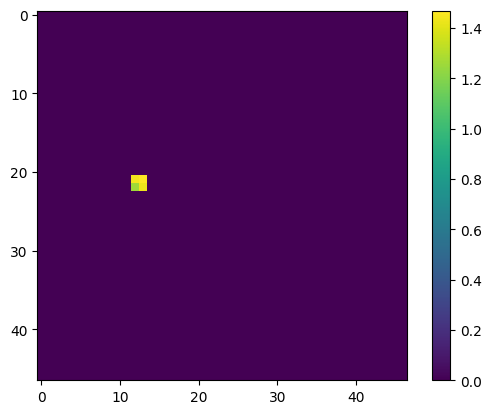

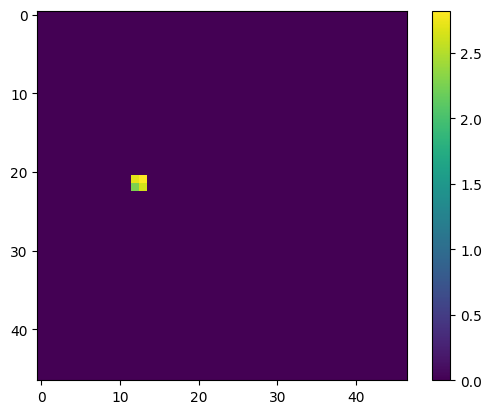

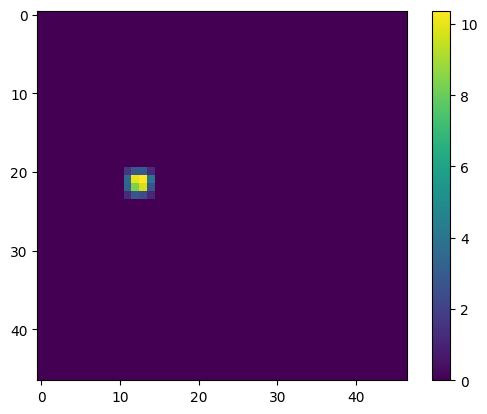

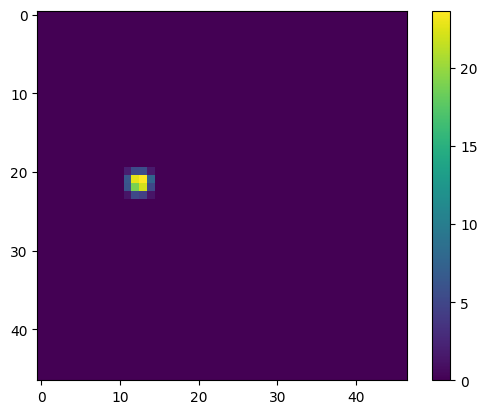

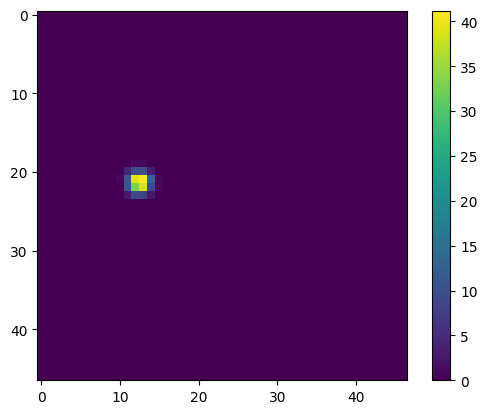

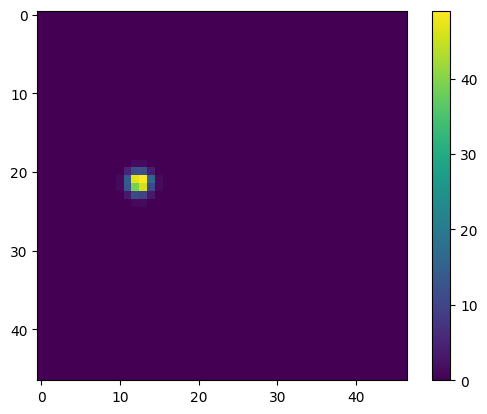

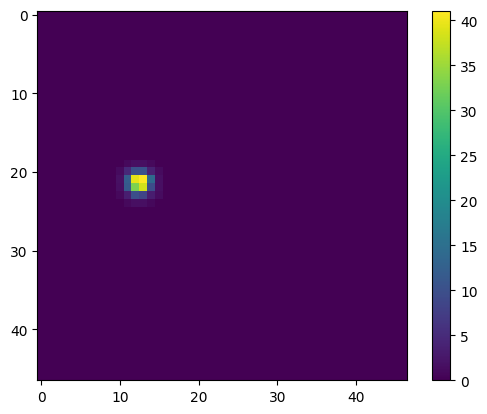

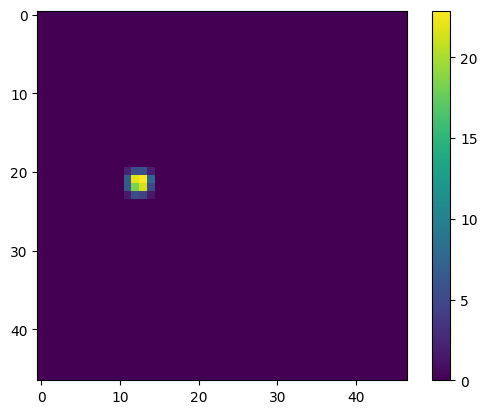

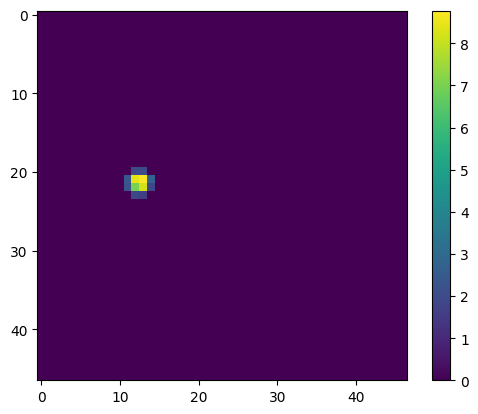

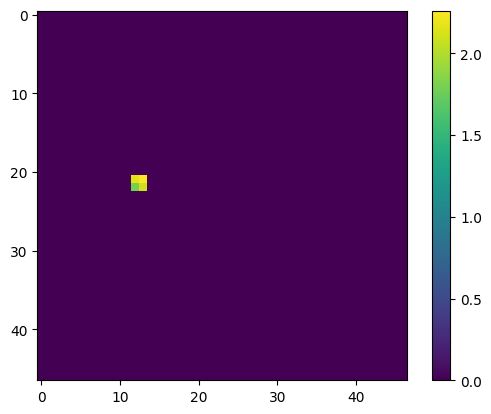

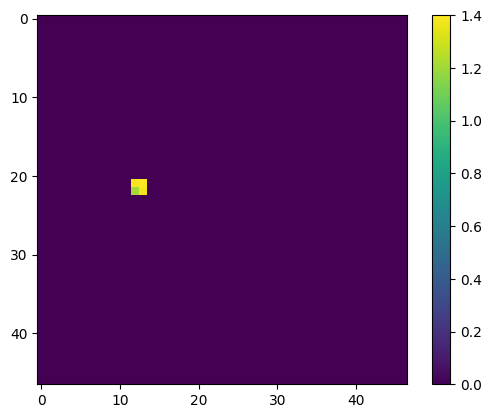

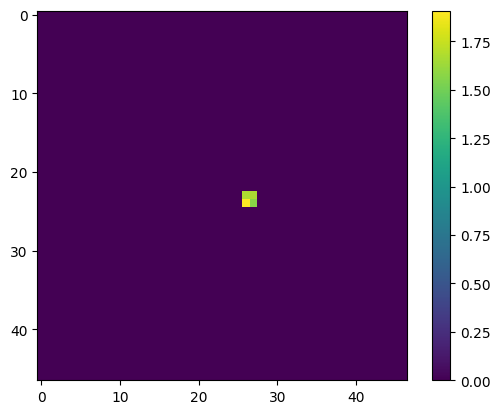

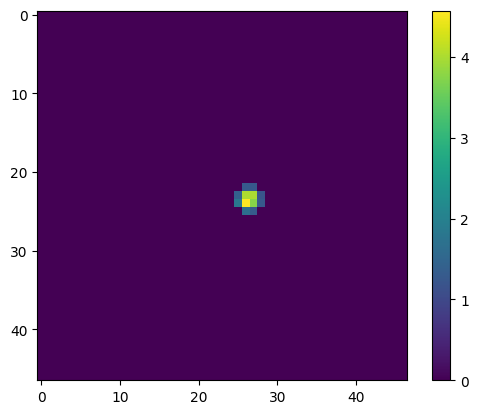

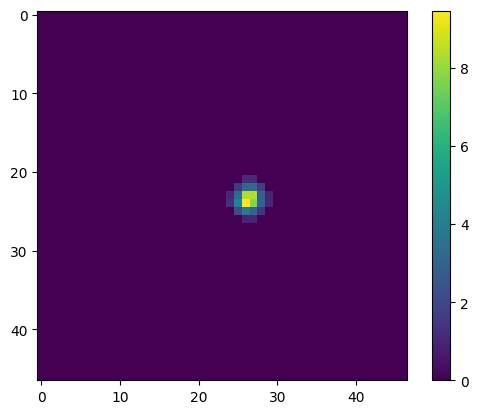

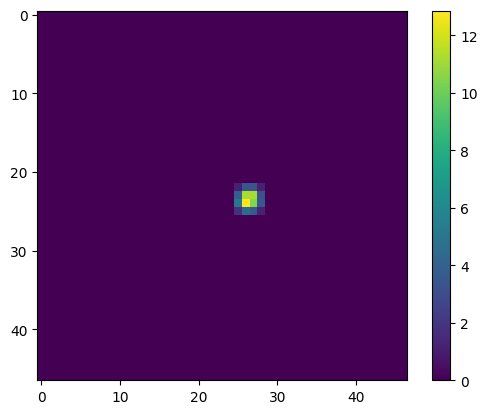

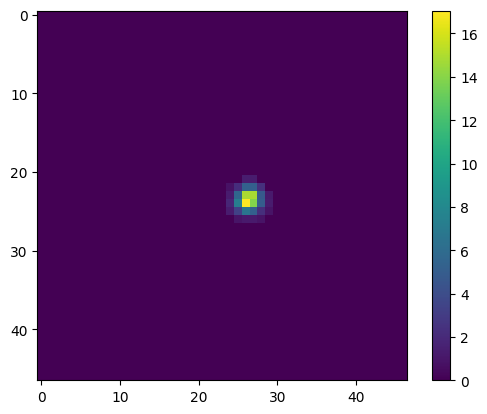

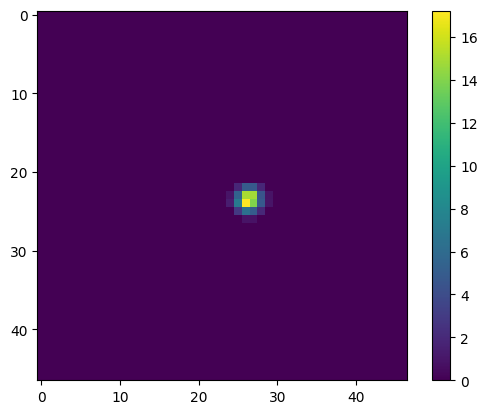

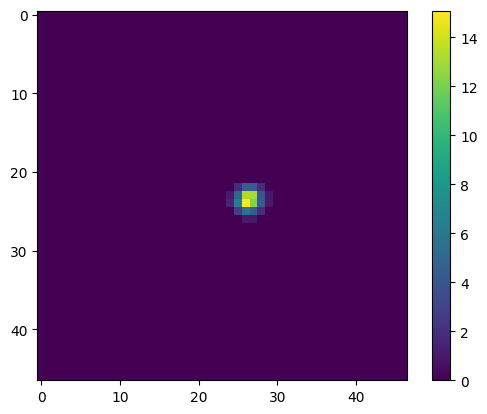

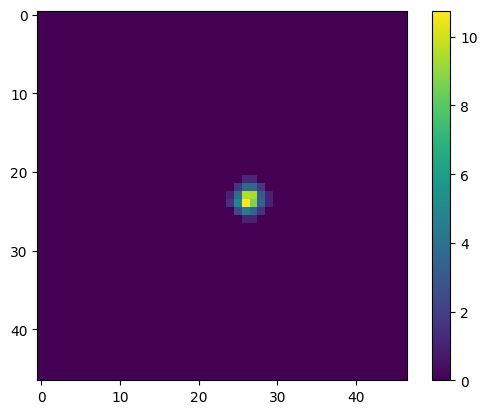

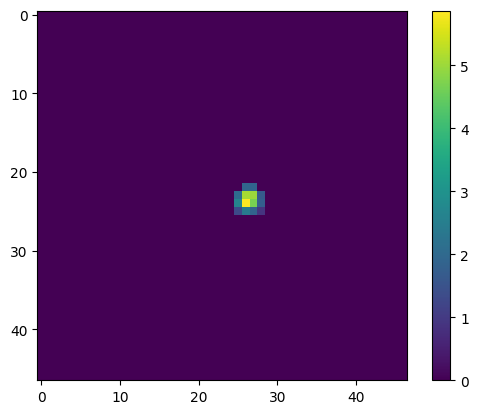

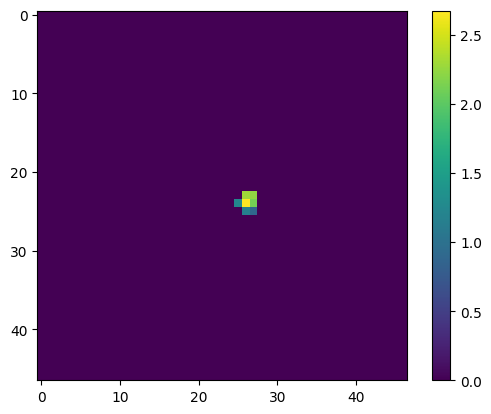

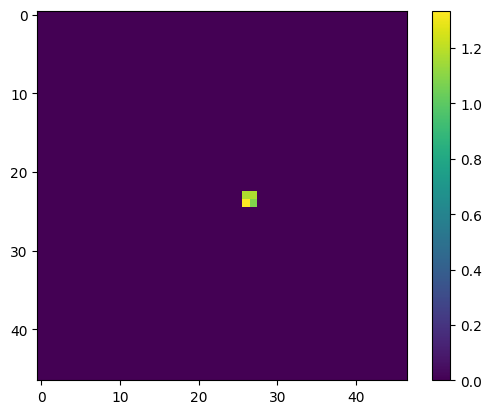

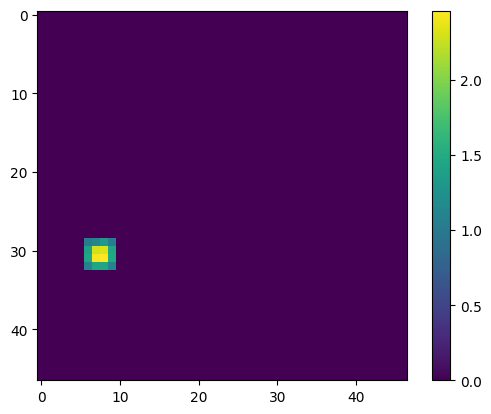

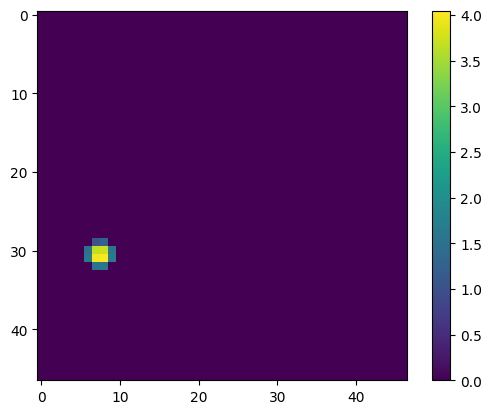

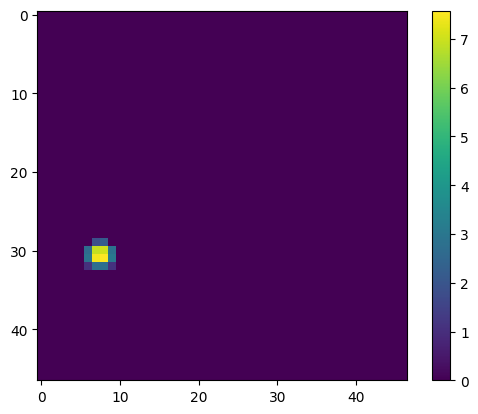

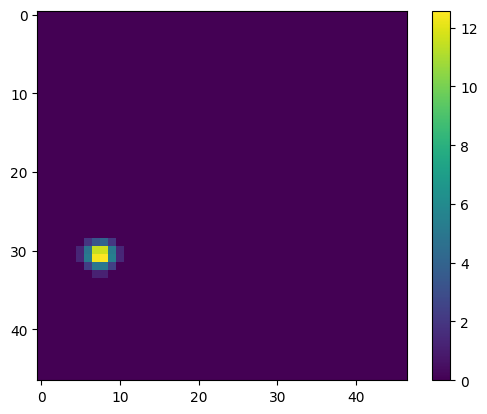

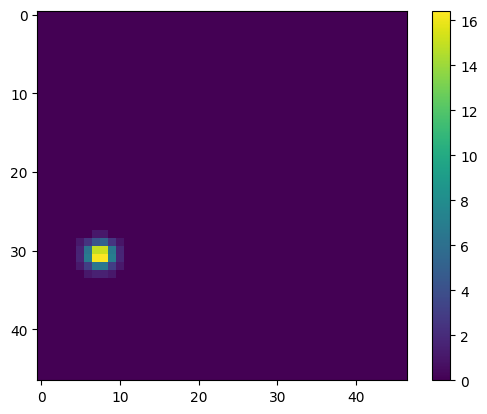

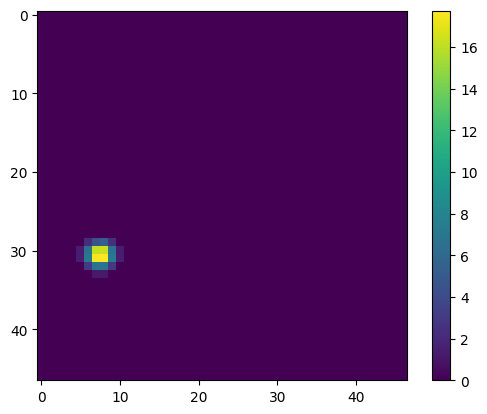

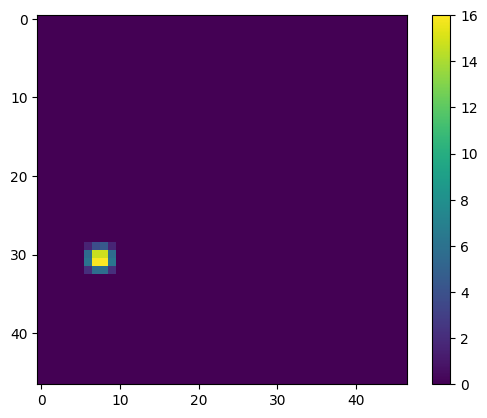

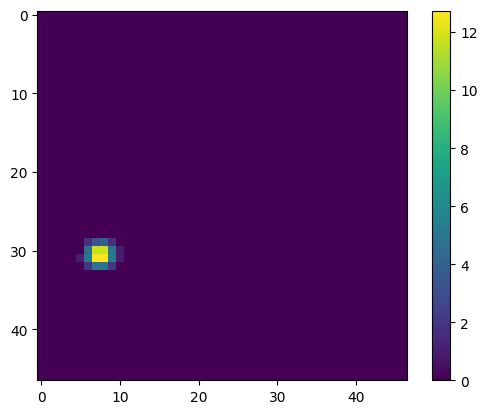

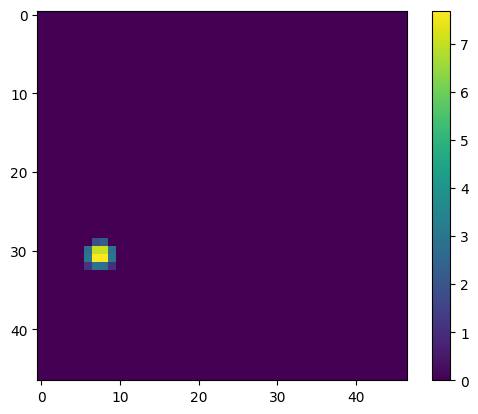

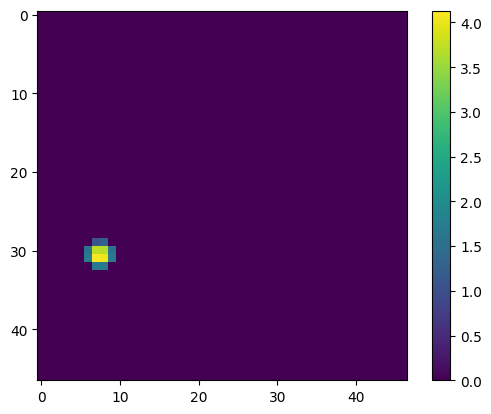

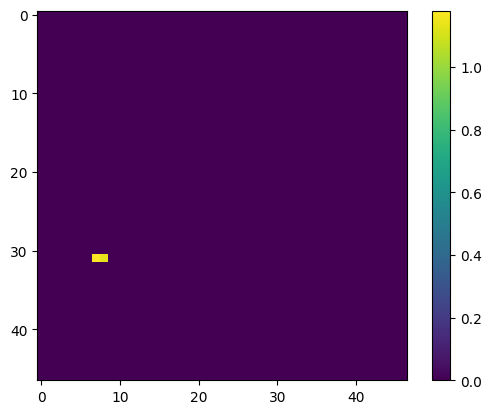

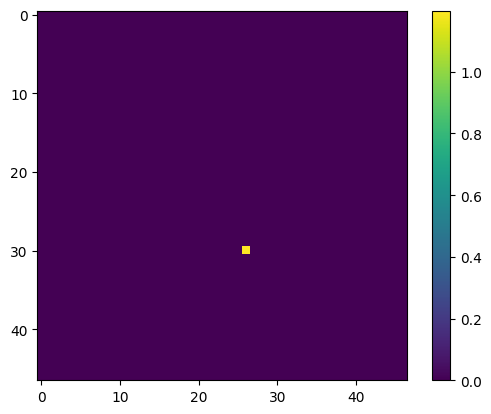

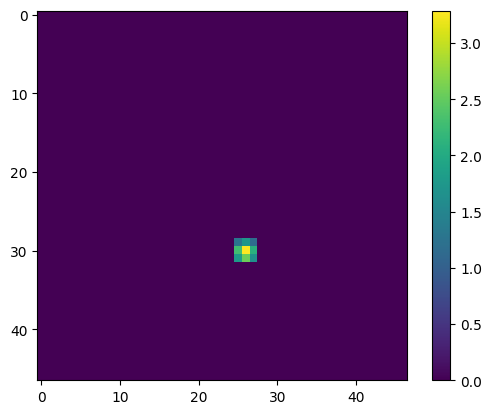

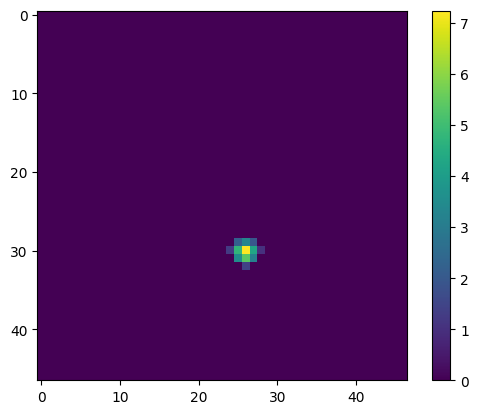

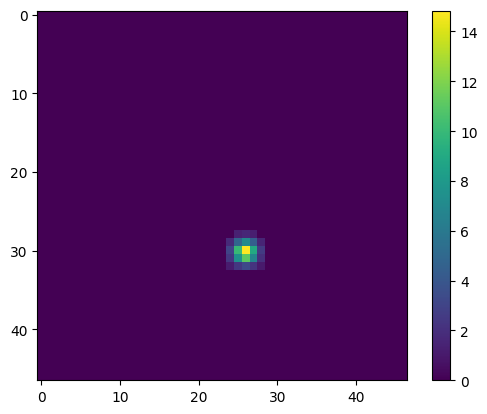

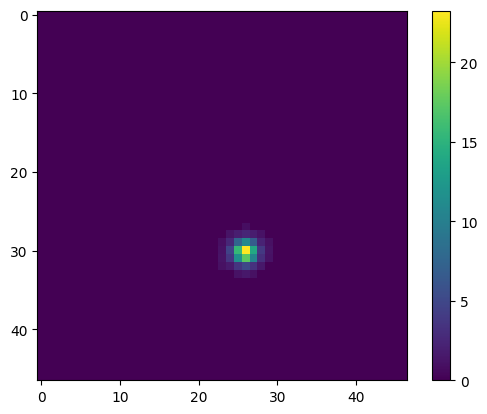

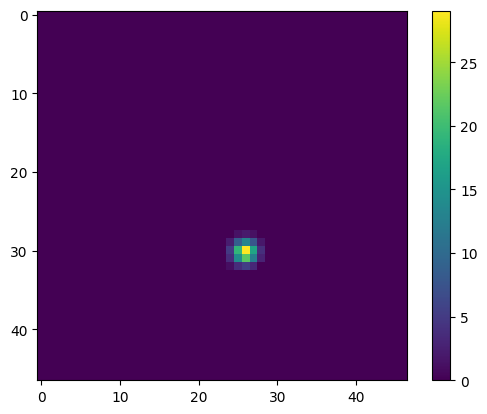

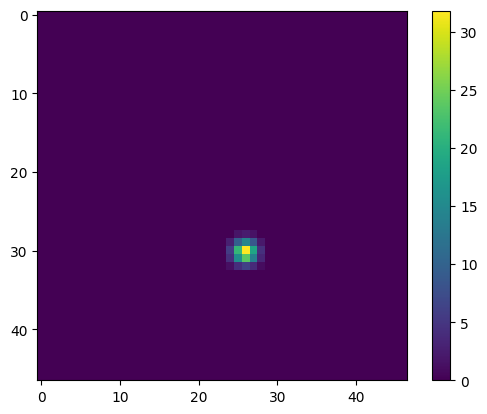

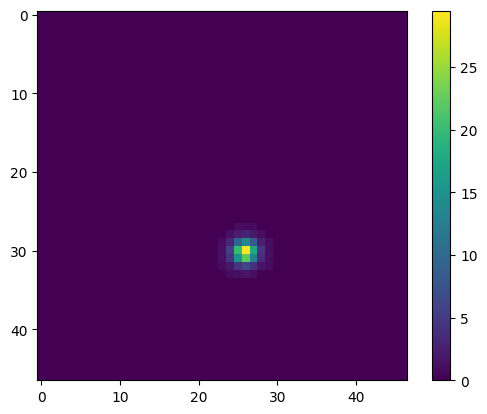

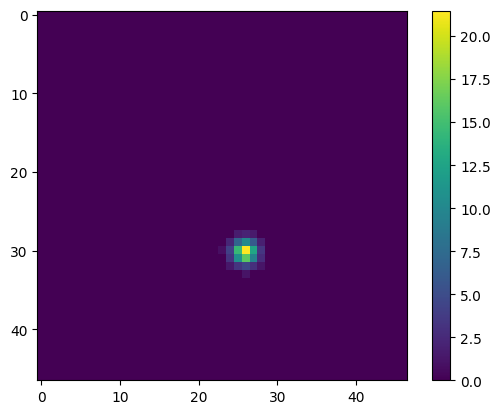

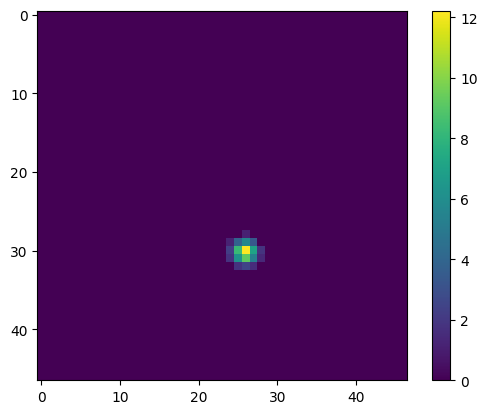

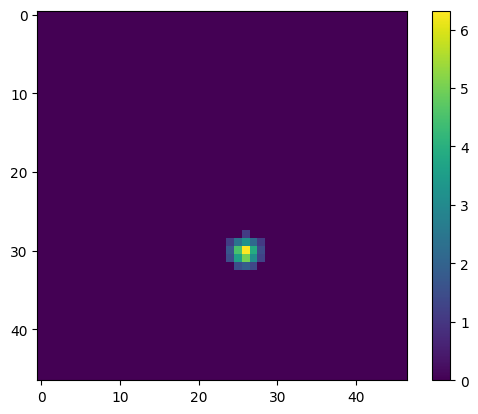

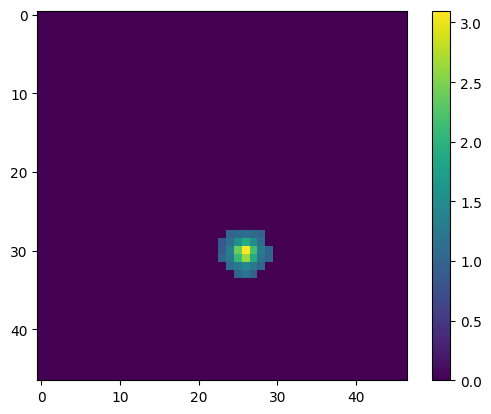

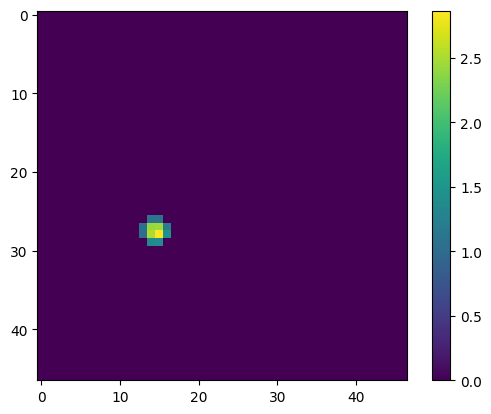

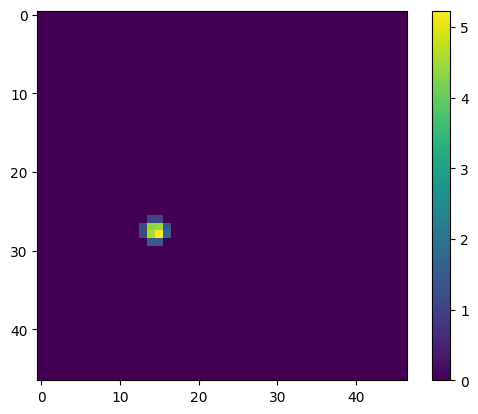

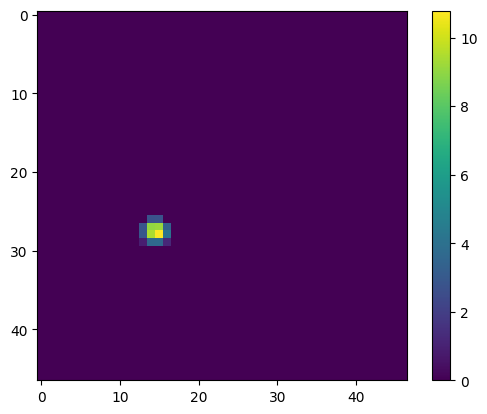

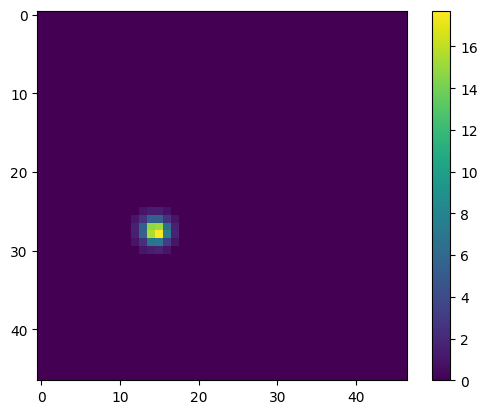

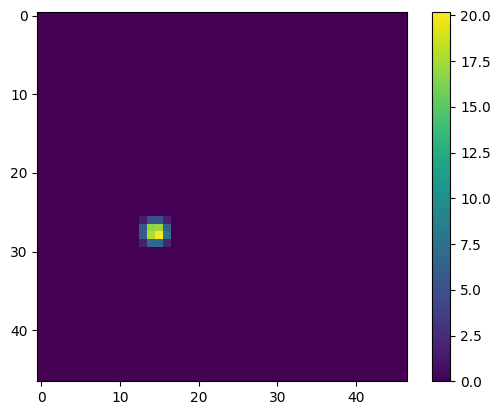

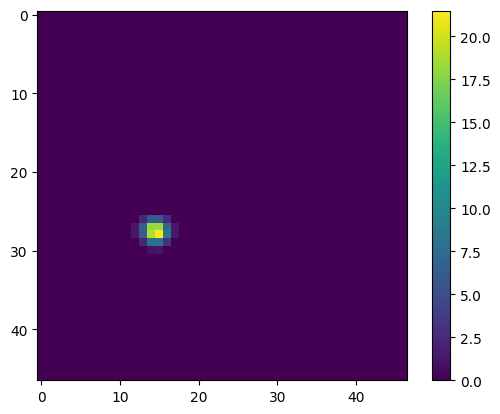

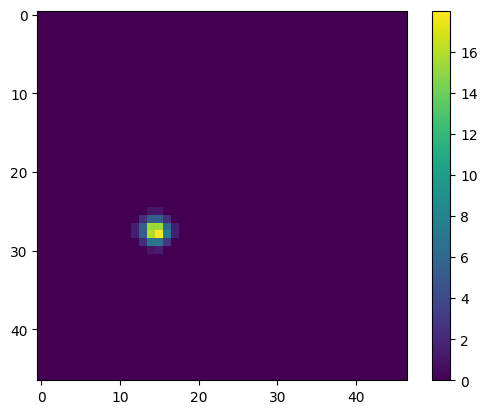

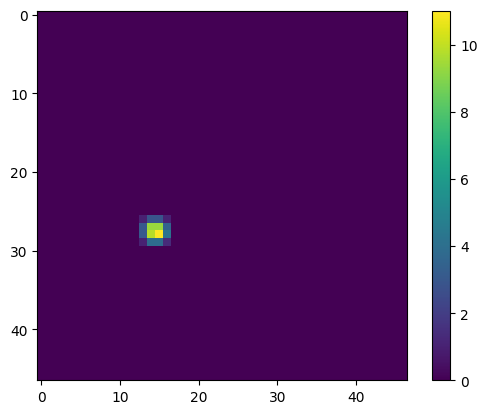

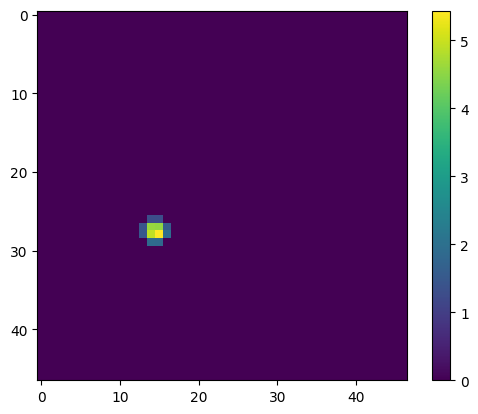

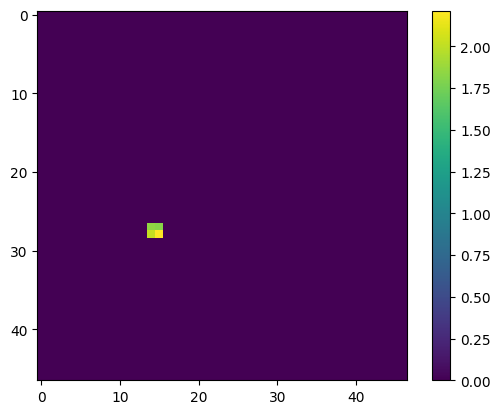

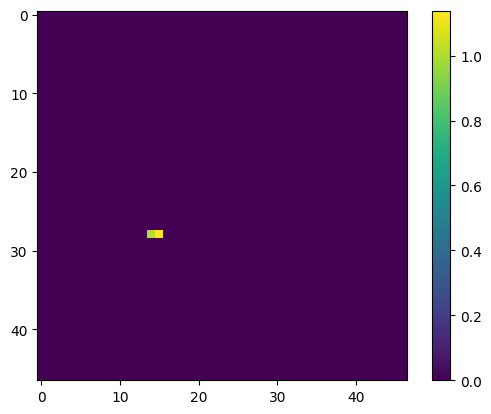

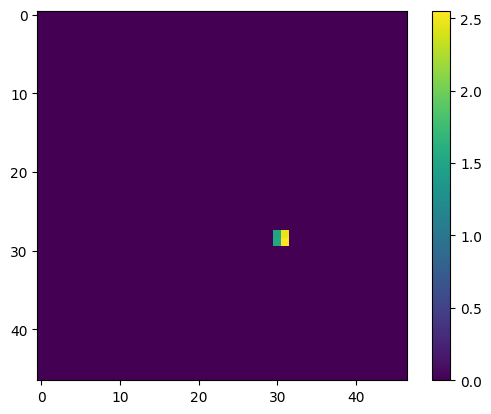

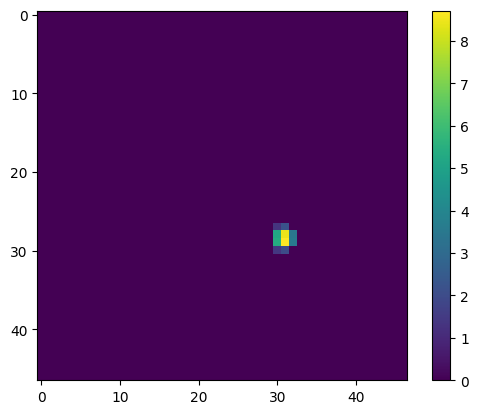

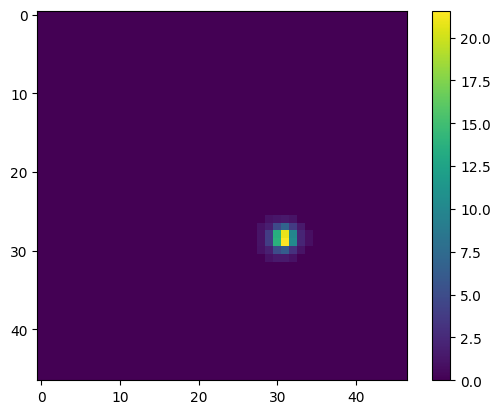

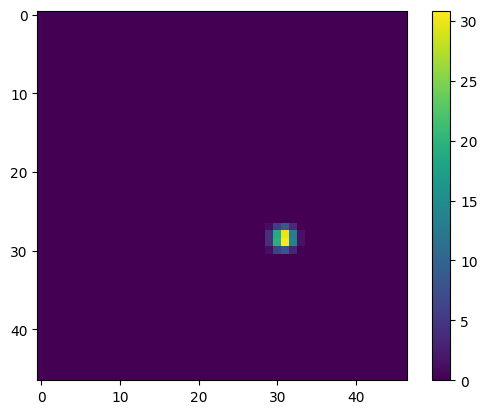

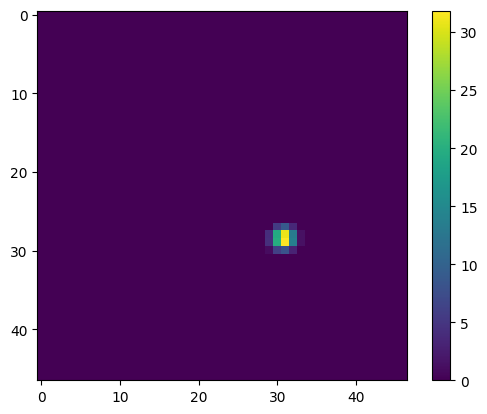

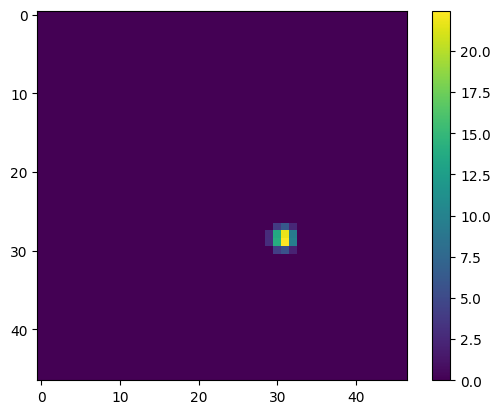

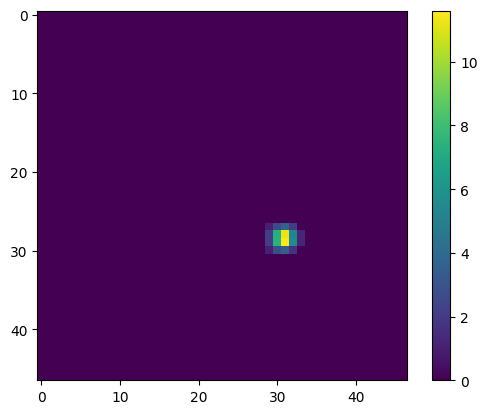

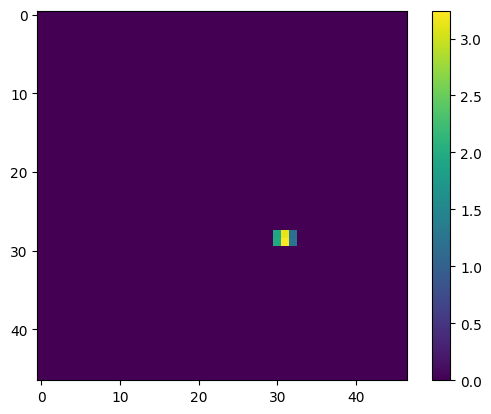

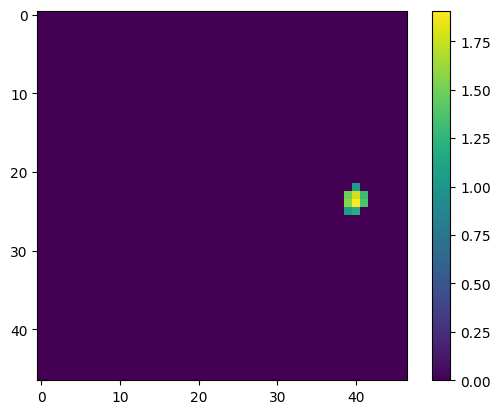

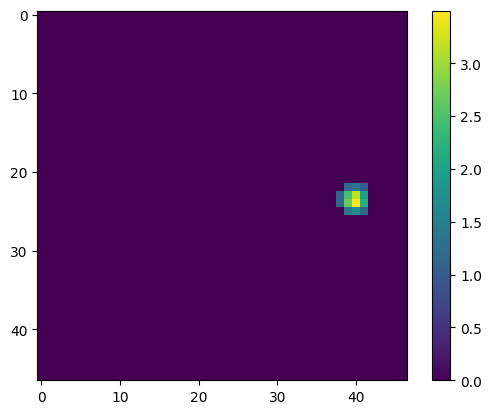

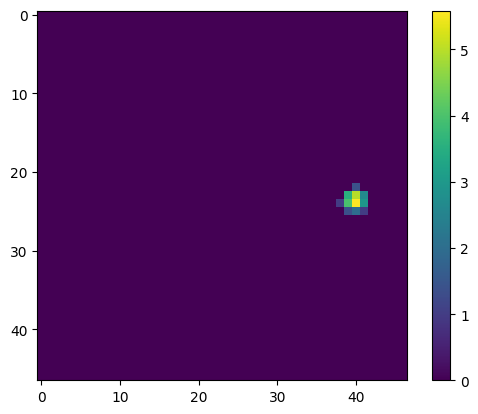

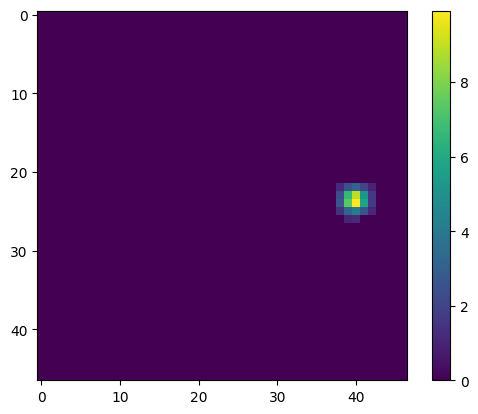

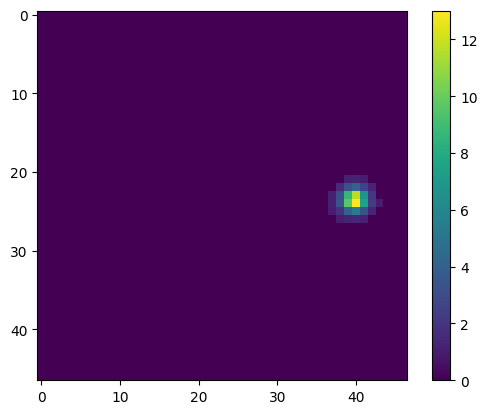

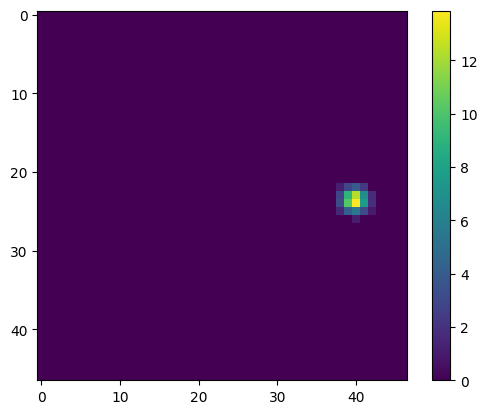

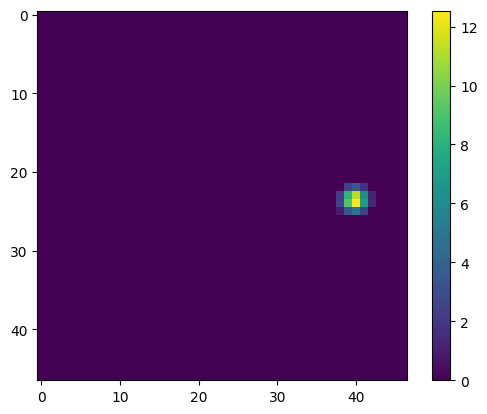

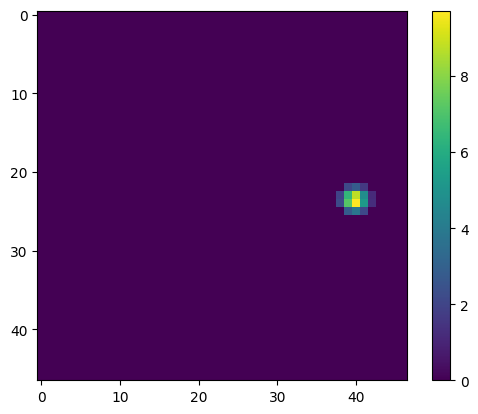

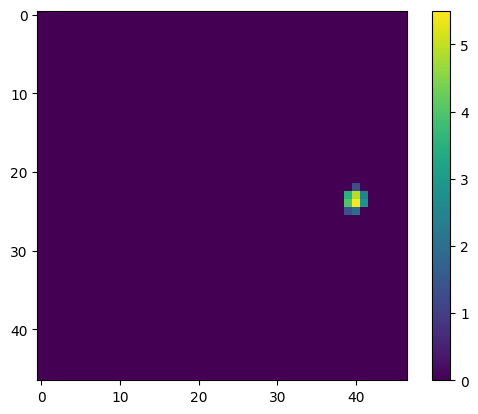

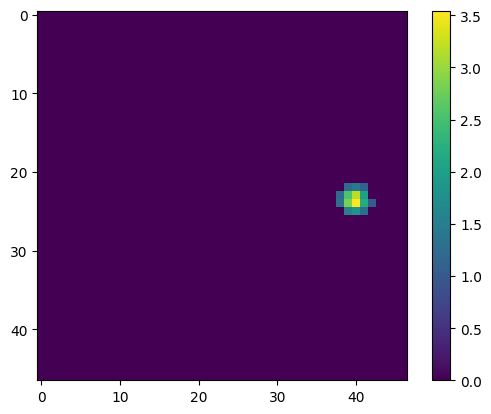

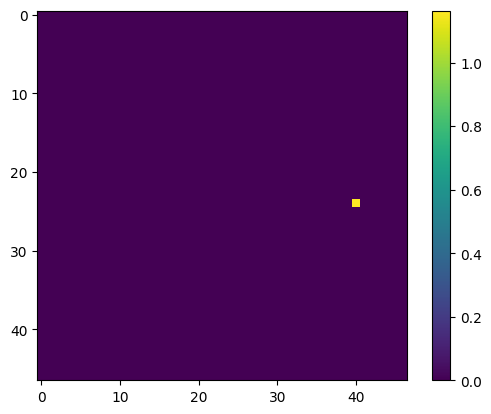

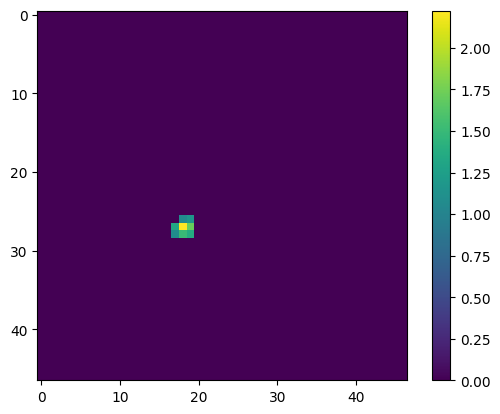

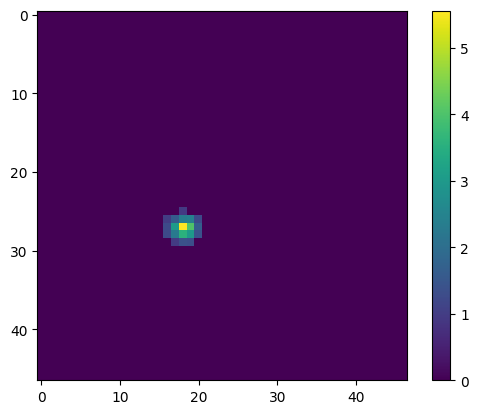

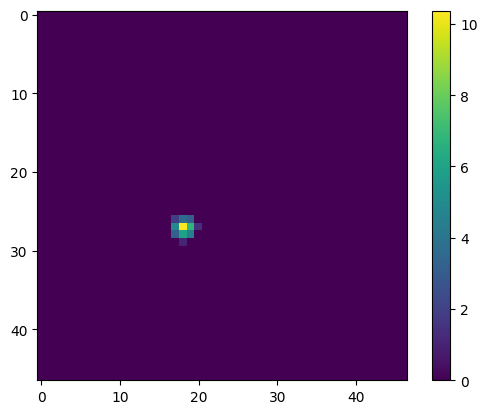

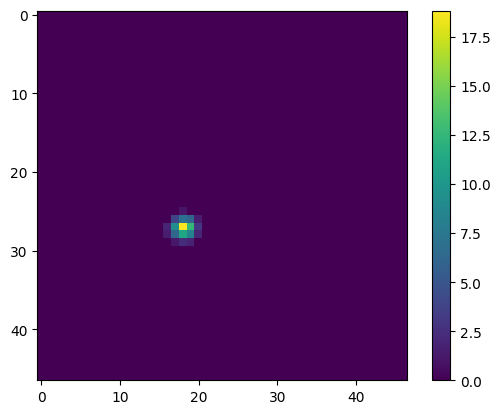

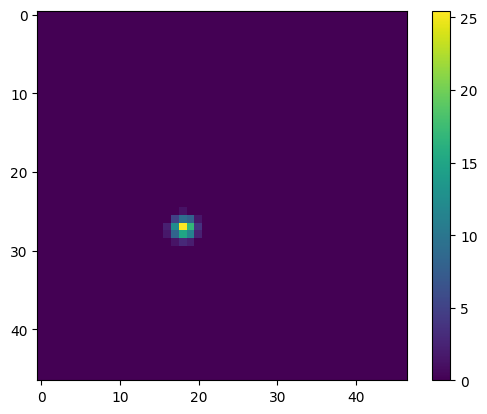

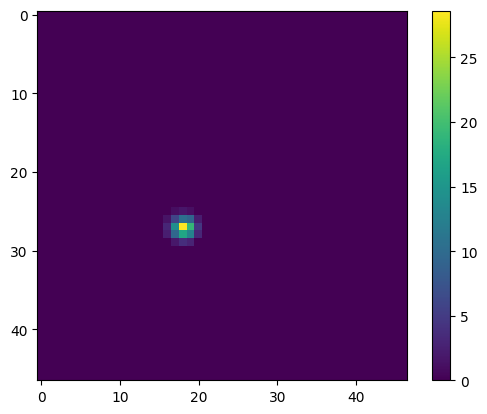

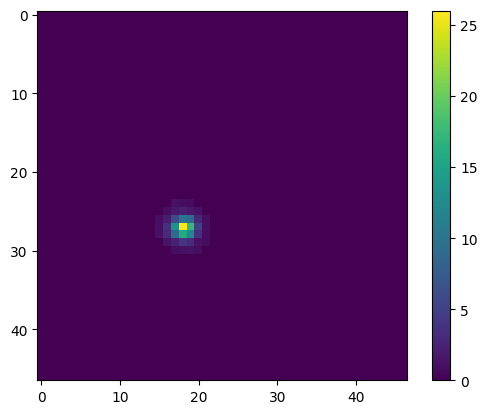

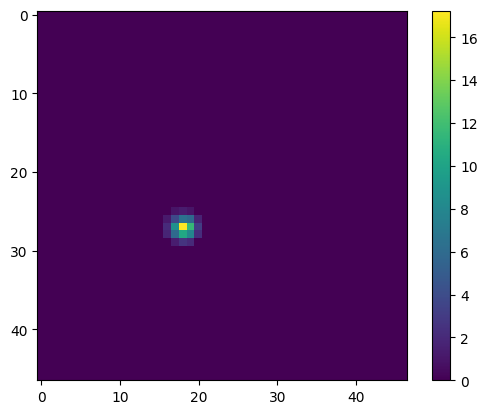

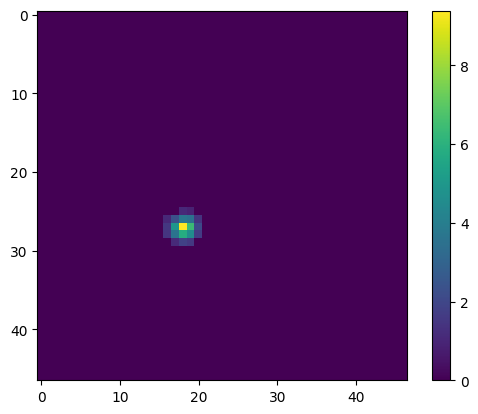

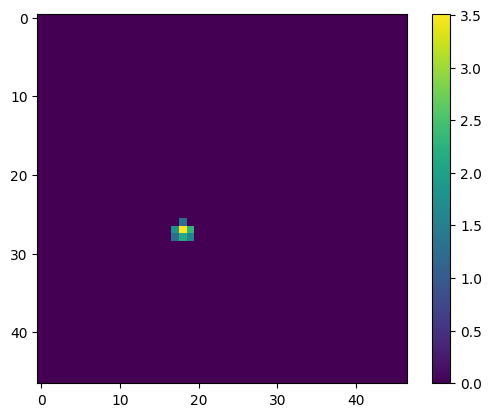

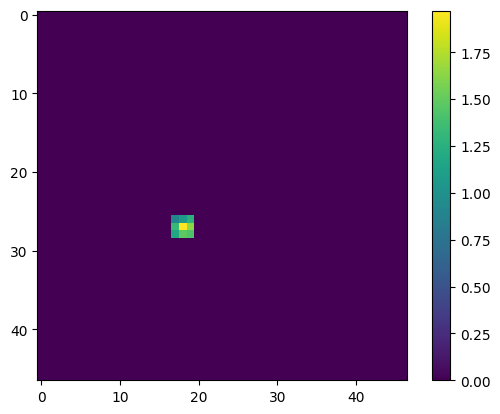

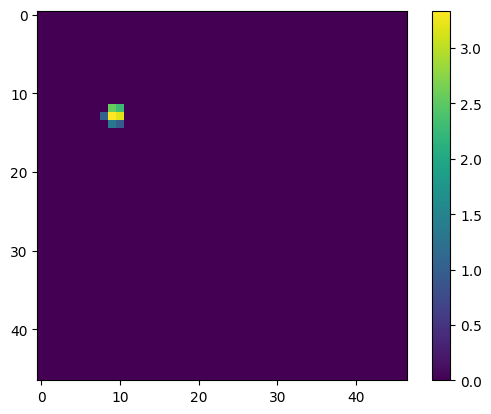

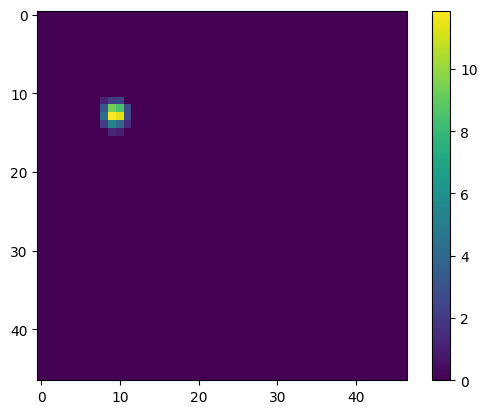

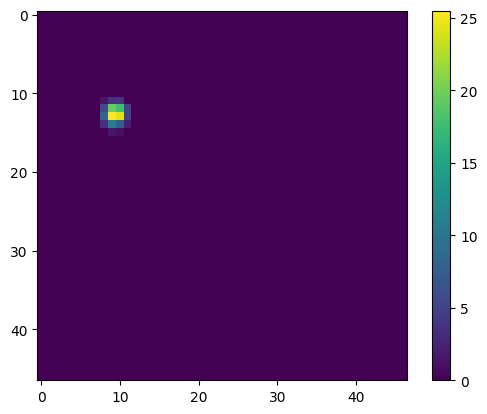

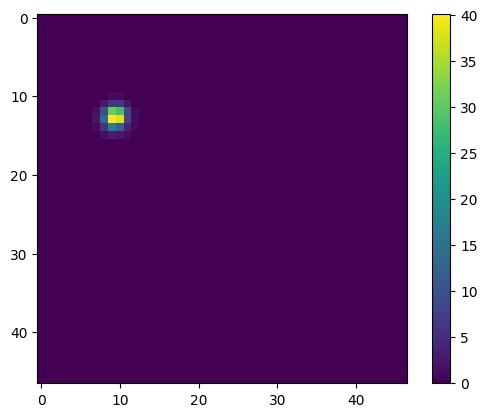

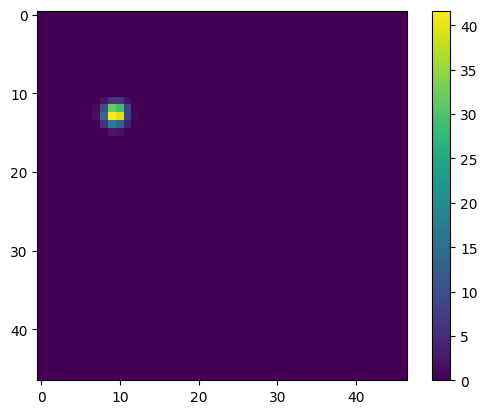

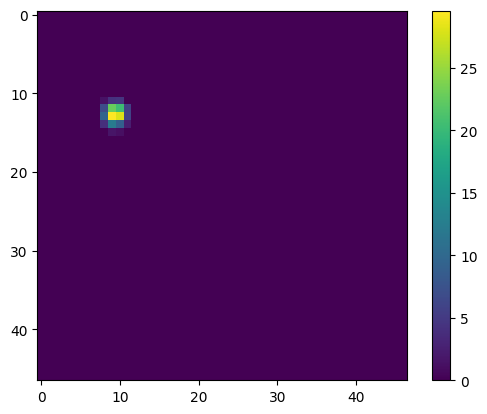

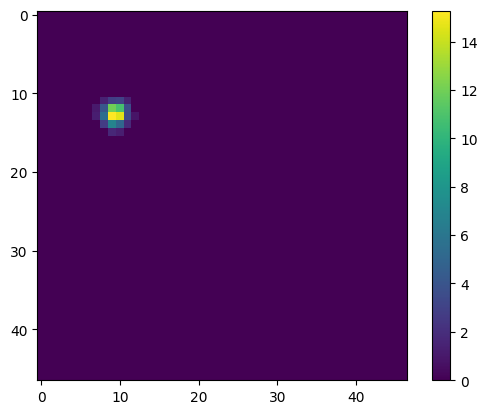

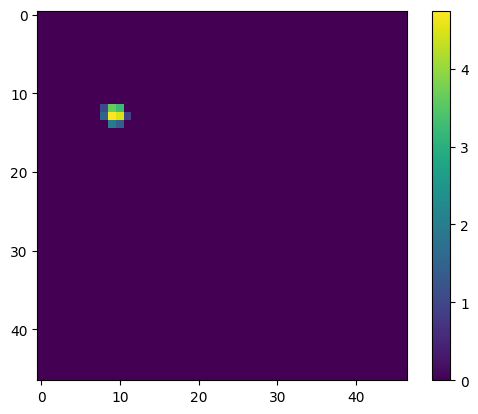

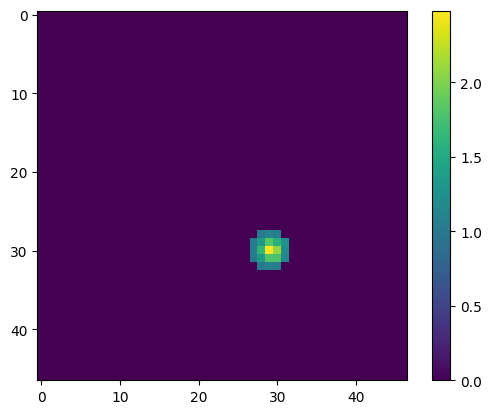

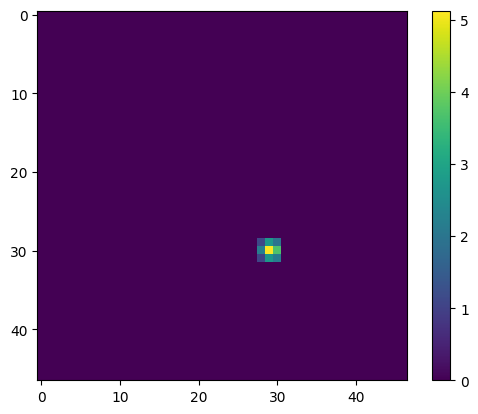

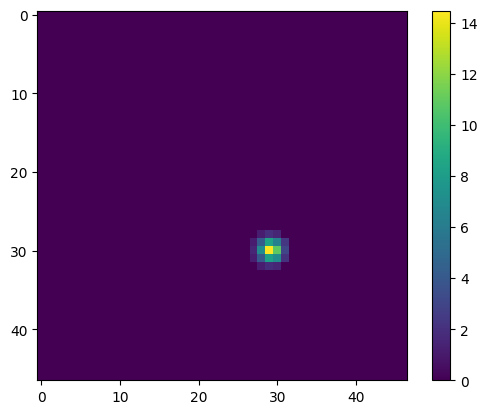

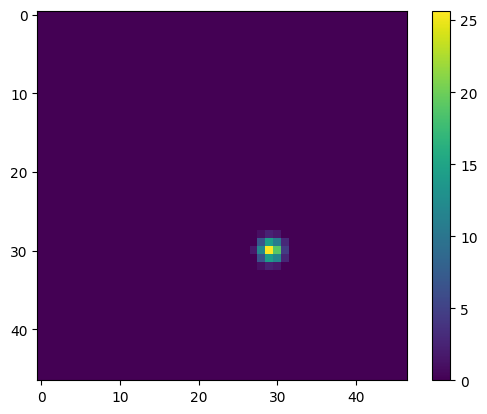

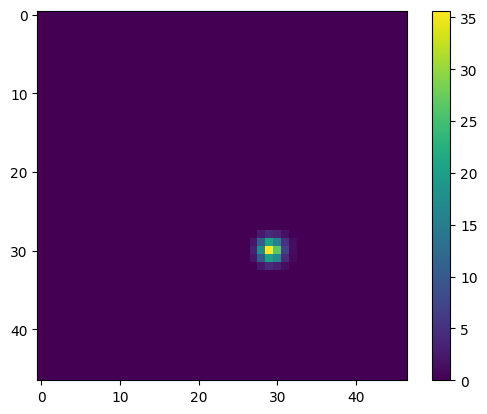

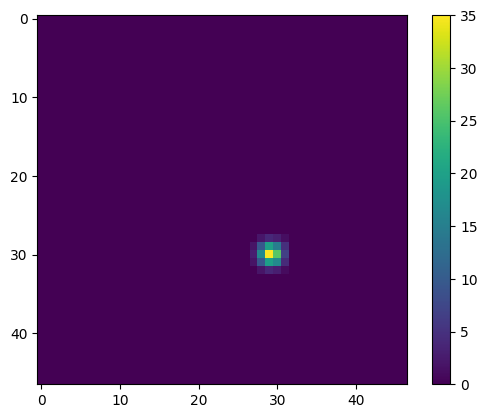

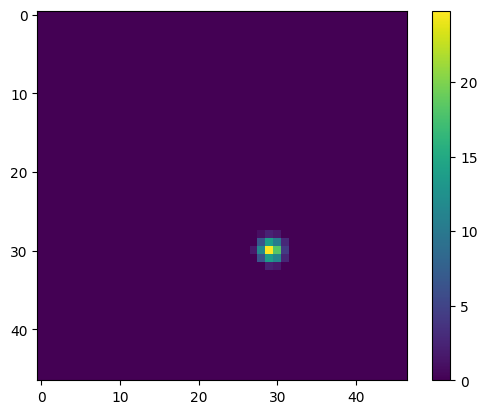

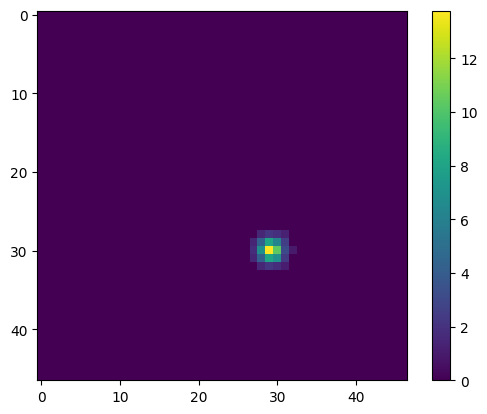

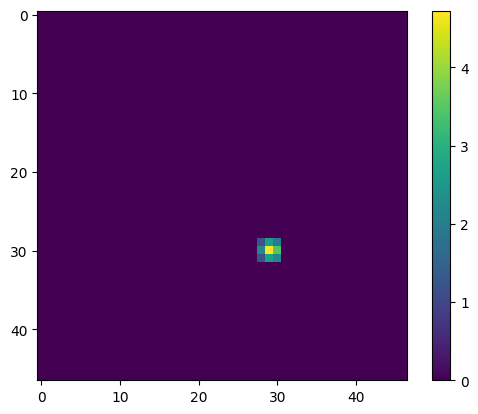

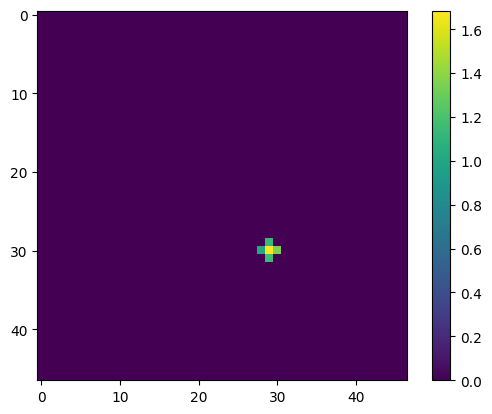

In [29]:
for i in range(0,reshaped_array.shape[0]):
    plt.imshow(reshaped_array[i])
    plt.colorbar()
    plt.show()

In [ ]:
shaped_sipm = simulated_sipms.reshape((-1,47,47))
shaped_real = batch['S2Si'].reshape((-1,47,47))

def label(array,val):
    print(array.shape)
    empty = jnp.empty(shape =1)
    labels = jax.lax.select(val == 1, jnp.array([0,1]), jnp.array([1,0]))
       
    return labels

final =jit(vmap(label,in_axes=[0,None]))

In [287]:
labels_fake = final(shaped_sipm,1)
labels_real = final(shaped_real,0)

#print(labels_fake.shape)

events = jnp.vstack([shaped_real,shaped_sipm])
labels = jnp.vstack([labels_real,labels_fake])

train, labels = sklearn.utils.shuffle(events,labels)


In [268]:
dis_init, dis_apply = stax.serial(
        stax.Flatten,
        stax.Dense(128),stax.Sigmoid,
        stax.Dense(16), stax.Sigmoid,
        stax.Dense(2),stax.Softmax
    )
    
dis_out_size, dis_network_params = dis_init(subkey,(1,47,47))

parameters = {
'D_parameters': dis_network_params,
'S_parameters': sim_params,
}

In [271]:
gen_labels = dis_apply(parameters['D_parameters'],train)

loss = binary_cross_entropy(labels,gen_labels)

print(loss)

0.7892733


In [249]:
simulated_sipms.reshape((-1,47,47)).shape


(5500, 47, 47)